# Training Phase

## Importing library

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Concatenate
from tensorflow.keras.models import Model
import json
from tensorflow.keras.models import load_model

## Some code to support execution

In [2]:
tf.keras.backend.clear_session()

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, True)

## Setting up the variable to contain data as well as displaying class names

In [4]:
data_path = 'image_dataset'

x,y = [],[]

class_names = os.listdir(data_path)

print(class_names)

['battery', 'clothing_waste', 'glass', 'metal', 'organic', 'paper', 'plastic']


## Function for resizing and padding

In [5]:
def pad_image(img):
    height, width = img.shape[:2]

    height_padding = (96 - height % 96) % 96
    width_padding = (96 - width % 96) % 96

    top_padding = height_padding // 2
    bottom_padding = height_padding - top_padding
    left_padding = width_padding // 2
    right_padding = width_padding - left_padding

    padded_img = cv2.copyMakeBorder(
        img, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=[0, 0, 0]
    )

    return padded_img

def resize_image(img):
    return cv2.resize(img, (96,96), interpolation=cv2.INTER_LANCZOS4)

## Loading the data into x and y variable

In [6]:
for index, class_path in enumerate(class_names):
    for image in os.listdir(os.path.join(data_path, class_path)):
        
        img = cv2.imread(os.path.join(data_path, class_path, image))

        padded_img = pad_image(img)
        resized_img = resize_image(padded_img)

        rgb_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
        
        x.append(rgb_img)
        y.append(index)

In [7]:
x,y = np.array(x),np.array(y)

## The image count of each class/category

In [8]:
unique, counts = np.unique(y, return_counts=True)
category_counts = dict(zip(class_names, counts))

for category, count in category_counts.items():
    print(f"{category}: {count}")

battery: 945
clothing_waste: 970
glass: 1000
metal: 999
organic: 985
paper: 1105
plastic: 941


## Sample image

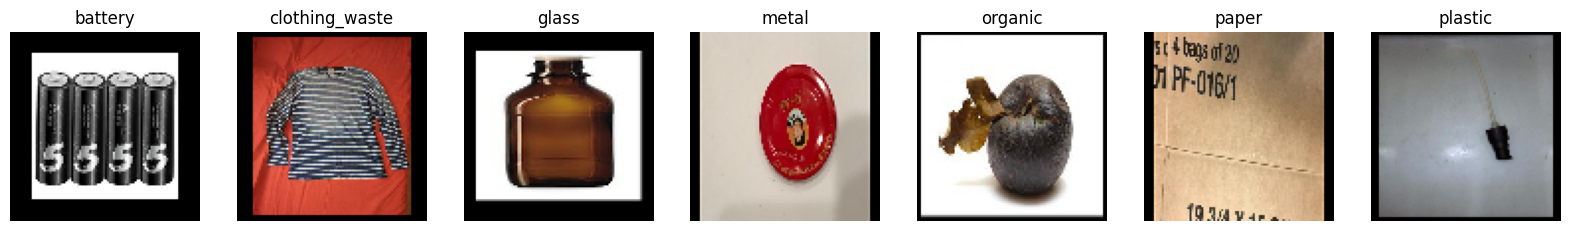

In [9]:
fig, axes = plt.subplots(1, len(class_names), figsize=(20, 5))

for i, class_name in enumerate(class_names):
    class_index = class_names.index(class_name)
    image_index = np.where(y == class_index)[0][12]
    axes[i].imshow(x[image_index])
    axes[i].set_title(class_name)
    axes[i].axis('off')

plt.show()

## Splitting data into training and testing

80% for training, 10% for validation and 10% for testing

In [10]:
x_train,x_temp,y_train,y_temp = train_test_split(x,y,test_size=0.2,stratify=y,random_state=42)

x_val,x_test,y_val,y_test = train_test_split(x_temp,y_temp,test_size=0.5,stratify=y_temp,random_state=42)

In [11]:
x_train.shape

(5556, 96, 96, 3)

## Data augmentation

In [12]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(

    rotation_range=20,

    width_shift_range=0.14,

    height_shift_range=0.14,

    horizontal_flip=True,

    zoom_range=0.11,

    brightness_range=[0.9,1.1],

    shear_range=0.12,

    channel_shift_range=0.1,

)

In [13]:
x_train = data_generator.flow(x_train, y_train, batch_size=len(x_train))
x_train,y_train = next(x_train)

## Extracting orb feature 

Finding max length of keypoint and descriptor

In [14]:
def extractSIFT_no_padding(img):
    img = img.astype(np.uint8)
    gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(blur_image, None)
    return kp,des 

keypoints,descriptors = zip(*[extractSIFT_no_padding(img) for img in x_train])

max_keypoints = max(len(kp) for kp in keypoints)
print(f"Maximum keypoints found in any image: {max_keypoints}")

# Calculate maximum number of descriptors in any image
max_descriptors = max(des.shape[0] if des is not None else 0 for des in descriptors)
print(f"Maximum descriptors found in any image: {max_descriptors}")

Maximum keypoints found in any image: 259
Maximum descriptors found in any image: 259


In [15]:
def extract_sift_features(img, max_keypoints=100, max_descriptors=100):
    img = img.astype(np.uint8)
    gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
    sift = cv2.SIFT_create()
    keypoints, descriptor = sift.detectAndCompute(blur_image, None)
    
    # Initialize lists to store keypoint data
    keypoint_positions = []
    keypoint_sizes = []
    keypoint_angles = []

     # If there are keypoints, populate the lists
    if keypoints:
        for kp in keypoints:
            keypoint_positions.append([kp.pt[0], kp.pt[1]])  # (x, y)
            keypoint_sizes.append(kp.size)
            keypoint_angles.append(kp.angle)

        # Convert lists to numpy arrays for calculations
        keypoint_positions = np.array(keypoint_positions)
        keypoint_sizes = np.array(keypoint_sizes)
        keypoint_angles = np.array(keypoint_angles)

        # Ensure padding works even if fewer keypoints than max_keypoints
        if keypoint_positions.shape[0] < max_keypoints:
            pad_length = max_keypoints - keypoint_positions.shape[0]
            keypoint_positions = np.pad(keypoint_positions, ((0, pad_length), (0, 0)), mode='constant')
            keypoint_sizes = np.pad(keypoint_sizes, (0, pad_length), mode='constant')
            keypoint_angles = np.pad(keypoint_angles, (0, pad_length), mode='constant')

        # Truncate if there are more keypoints than max_keypoints
        else:
            keypoint_positions = keypoint_positions[:max_keypoints]
            keypoint_sizes = keypoint_sizes[:max_keypoints]
            keypoint_angles = keypoint_angles[:max_keypoints]

        # Calculate aggregated keypoint stats (mean and std)
        keypoint_stats = np.concatenate([
            np.mean(keypoint_positions, axis=0),  # mean (x, y)
            np.std(keypoint_positions, axis=0),   # std (x, y)
            [np.mean(keypoint_sizes), np.std(keypoint_sizes)],  # mean and std of sizes
            [np.mean(keypoint_angles), np.std(keypoint_angles)]  # mean and std of angles
        ])
    else:
        # If no keypoints, return zero-filled stats
        keypoint_stats = np.zeros(8)

    if descriptor is not None:
        # Truncate or pad descriptors to a fixed length (e.g., max_descriptors x 32)
        if descriptor.shape[0] > max_descriptors:
            descriptor = descriptor[:max_descriptors]
        elif descriptor.shape[0] < max_descriptors:
            padding = np.zeros((max_descriptors - descriptor.shape[0], descriptor.shape[1]))
            descriptor = np.vstack([descriptor, padding])
        descriptor = descriptor.flatten()  # Flatten to 1D
    else:
        # If no descriptors, return a zero-padded vector
        descriptor = np.zeros(max_descriptors * 128) 

    return keypoint_stats, descriptor

Extracting keypoints and descriptors of each image

In [16]:
x_train_keypoints, x_train_descriptors = zip(*[extract_sift_features(img) for img in x_train])
x_train_keypoints = np.array(x_train_keypoints)
x_train_descriptors = np.array(x_train_descriptors)

x_test_keypoints, x_test_descriptors = zip(*[extract_sift_features(img) for img in x_test])
x_test_keypoints = np.array(x_test_keypoints)
x_test_descriptors = np.array(x_test_descriptors)

x_val_keypoints, x_val_descriptors = zip(*[extract_sift_features(img) for img in x_val])
x_val_keypoints = np.array(x_val_keypoints)
x_val_descriptors = np.array(x_val_descriptors)

## Normalizing to 0-1

In [17]:
x_train = x_train.astype("float32")/255.0
x_test = x_test.astype("float32")/255.0
x_val = x_val.astype("float32")/255.0

## Model architecture

In [18]:
# Image branch (ResNet for visual features)
image_input = Input(shape=(96, 96, 3), name="image_input")
resnet_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=image_input,
    pooling="avg"
)

# Descriptor branch (aggregated feature descriptor from ORB
descriptor_input = Input(shape=(x_train_descriptors[0].shape), name="descriptor_input")  
x_descriptor = Dense(64, activation="relu")(descriptor_input)
x_descriptor = BatchNormalization()(x_descriptor)
x_descriptor = Dropout(0.25)(x_descriptor)

# Keypoint branch (aggregated feature descriptor from ORB
keypoint_input = Input(shape=(x_train_keypoints[0].shape), name="keypoint_input")  
x_keypoint = Dense(32, activation="relu")(keypoint_input)
x_keypoint = BatchNormalization()(x_keypoint)
x_keypoint = Dropout(0.25)(x_keypoint)

# Combine the branches
x_combined = Concatenate()([resnet_model.output, x_descriptor,x_keypoint])
x_combined = Dense(128, activation="relu")(x_combined)
x_combined = BatchNormalization()(x_combined)
x_combined = Dropout(0.25)(x_combined)
x_combined = Dense(80, activation="relu")(x_combined)
x_combined = BatchNormalization()(x_combined)
x_combined = Dropout(0.25)(x_combined)
x_combined = Dense(64, activation="relu")(x_combined)
x_combined = BatchNormalization()(x_combined)
x_combined = Dropout(0.25)(x_combined)

# Output layer
output = Dense(7, activation="softmax")(x_combined)

# Define the model
model = Model(inputs=[image_input, descriptor_input,keypoint_input], outputs=output)


In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 102, 102, 3)  0           ['image_input[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)            (None, 48, 48, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 48, 48, 64)   256         ['conv1_conv[0][0]']             
                                                                                              

## Setting up the data to feed the model

In [20]:
train_data = {"image_input": x_train, "descriptor_input": x_train_descriptors, "keypoint_input": x_train_keypoints}
val_data = {"image_input": x_val, "descriptor_input": x_val_descriptors, "keypoint_input": x_val_keypoints}
test_data = {"image_input": x_test, "descriptor_input": x_test_descriptors, "keypoint_input": x_test_keypoints}

In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(verbose=1, patience=10, monitor="val_loss", restore_best_weights=True)

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(2e-5), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [23]:
history = model.fit(train_data, y_train, validation_data=(val_data, y_val), epochs=30, batch_size=8,callbacks=[early_stopping])

Epoch 1/30
695/695 [==============================] - 70s 85ms/step - loss: 2.3769 - accuracy: 0.2262 - val_loss: 2.1573 - val_accuracy: 0.2075
Epoch 2/30
695/695 [==============================] - 60s 86ms/step - loss: 1.8616 - accuracy: 0.3593 - val_loss: 1.4727 - val_accuracy: 0.5216
Epoch 3/30
695/695 [==============================] - 58s 84ms/step - loss: 1.5714 - accuracy: 0.4548 - val_loss: 1.2447 - val_accuracy: 0.6066
Epoch 4/30
695/695 [==============================] - 57s 82ms/step - loss: 1.4178 - accuracy: 0.5086 - val_loss: 1.0829 - val_accuracy: 0.6614
Epoch 5/30
695/695 [==============================] - 57s 82ms/step - loss: 1.2632 - accuracy: 0.5709 - val_loss: 0.9011 - val_accuracy: 0.7161
Epoch 6/30
695/695 [==============================] - 57s 82ms/step - loss: 1.1453 - accuracy: 0.6215 - val_loss: 0.7980 - val_accuracy: 0.7493
Epoch 7/30
695/695 [==============================] - 58s 84ms/step - loss: 1.0944 - accuracy: 0.6303 - val_loss: 0.6575 - val_accuracy:

# Evaluation Phase

In [24]:
print(model.evaluate(test_data, y_test))

22/22 [==============================] - 1s 38ms/step - loss: 0.3690 - accuracy: 0.8935
[0.3690108358860016, 0.8935251832008362]


## Accuracy & Loss vs EPOCH

Text(0, 0.5, 'Loss')

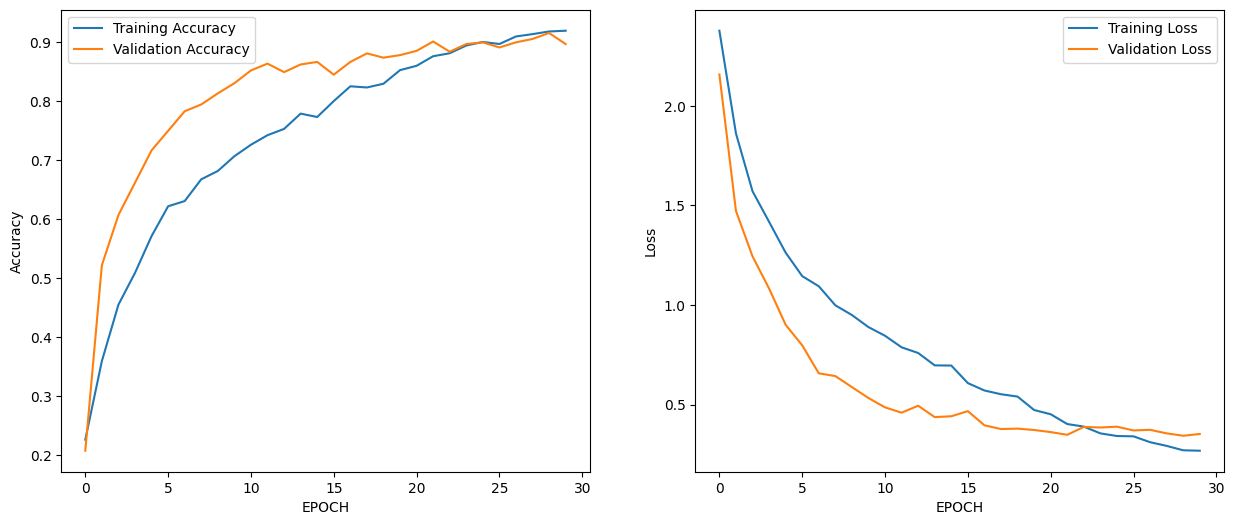

In [25]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],label = "Training Accuracy")
plt.plot(history.history['val_accuracy'],label = "Validation Accuracy")
plt.legend()
plt.xlabel('EPOCH')
plt.ylabel("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'],label = "Training Loss")
plt.plot(history.history['val_loss'],label = "Validation Loss")
plt.legend()
plt.xlabel('EPOCH')
plt.ylabel("Loss")

## Classification Report and confusion matrix

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

predictions = model.predict(test_data)

y_pred = np.argmax(predictions, axis=1)


print(classification_report(y_test, y_pred, target_names=class_names))

22/22 [==============================] - 2s 34ms/step
                precision    recall  f1-score   support

       battery       0.90      0.90      0.90        94
clothing_waste       0.89      0.98      0.93        97
         glass       0.86      0.90      0.88       100
         metal       0.81      0.94      0.87       100
       organic       0.98      0.89      0.93        99
         paper       0.92      0.92      0.92       111
       plastic       0.93      0.71      0.81        94

      accuracy                           0.89       695
     macro avg       0.90      0.89      0.89       695
  weighted avg       0.90      0.89      0.89       695



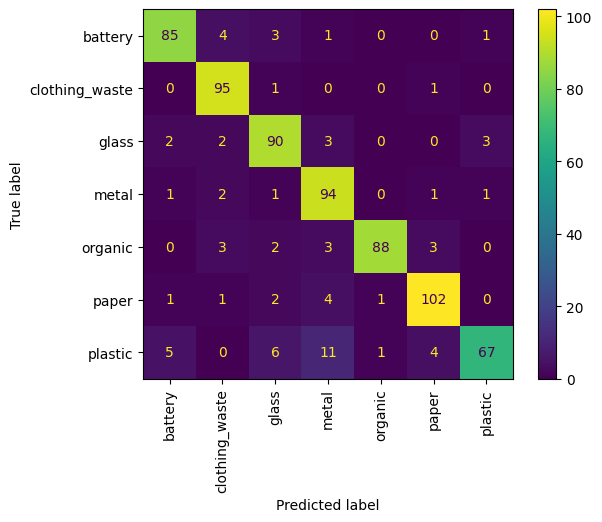

In [27]:
display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=class_names)
display.plot()
plt.xticks(rotation=90)
plt.show()

## Save model

In [ ]:
model.save("sift_model.h5")
max_feature_length = {'max_keypoint': 100, 'max_descriptor': 100}
with open('max_feature_length_sift.json', 'w') as file:
    json.dump(max_feature_length, file)

# Testing Phase

## Run all of this if you want to test on new images

Load model

In [6]:
sift_model = load_model("sift_model.h5")

with open('max_feature_length_sift.json', 'r') as file:
    max_feature_length = json.load(file)

max_keypoint = max_feature_length['max_keypoint']
max_descriptor = max_feature_length['max_descriptor']

print(max_keypoint, max_descriptor)

100 100


Padding and resizing

In [7]:
def pad_image(img):
    height, width = img.shape[:2]

    height_padding = (96 - height % 96) % 96
    width_padding = (96 - width % 96) % 96

    top_padding = height_padding // 2
    bottom_padding = height_padding - top_padding
    left_padding = width_padding // 2
    right_padding = width_padding - left_padding

    padded_img = cv2.copyMakeBorder(
        img, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=[0, 0, 0]
    )

    return padded_img

def resize_image(img):
    return cv2.resize(img, (96,96), interpolation=cv2.INTER_LANCZOS4)

SIFT extractor

In [9]:
def extract_sift_features(img, max_keypoints=max_keypoint, max_descriptors=max_descriptor):
    img = img.astype(np.uint8)
    gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
    sift = cv2.SIFT_create()
    keypoints, descriptor = sift.detectAndCompute(blur_image, None)
    
    # Initialize lists to store keypoint data
    keypoint_positions = []
    keypoint_sizes = []
    keypoint_angles = []

     # If there are keypoints, populate the lists
    if keypoints:
        for kp in keypoints:
            keypoint_positions.append([kp.pt[0], kp.pt[1]])  # (x, y)
            keypoint_sizes.append(kp.size)
            keypoint_angles.append(kp.angle)

        # Convert lists to numpy arrays for calculations
        keypoint_positions = np.array(keypoint_positions)
        keypoint_sizes = np.array(keypoint_sizes)
        keypoint_angles = np.array(keypoint_angles)

        # Ensure padding works even if fewer keypoints than max_keypoints
        if keypoint_positions.shape[0] < max_keypoints:
            pad_length = max_keypoints - keypoint_positions.shape[0]
            keypoint_positions = np.pad(keypoint_positions, ((0, pad_length), (0, 0)), mode='constant')
            keypoint_sizes = np.pad(keypoint_sizes, (0, pad_length), mode='constant')
            keypoint_angles = np.pad(keypoint_angles, (0, pad_length), mode='constant')

        # Truncate if there are more keypoints than max_keypoints
        else:
            keypoint_positions = keypoint_positions[:max_keypoints]
            keypoint_sizes = keypoint_sizes[:max_keypoints]
            keypoint_angles = keypoint_angles[:max_keypoints]

        # Calculate aggregated keypoint stats (mean and std)
        keypoint_stats = np.concatenate([
            np.mean(keypoint_positions, axis=0),  # mean (x, y)
            np.std(keypoint_positions, axis=0),   # std (x, y)
            [np.mean(keypoint_sizes), np.std(keypoint_sizes)],  # mean and std of sizes
            [np.mean(keypoint_angles), np.std(keypoint_angles)]  # mean and std of angles
        ])
    else:
        # If no keypoints, return zero-filled stats
        keypoint_stats = np.zeros(8)

    if descriptor is not None:
        # Truncate or pad descriptors to a fixed length (e.g., max_descriptors x 32)
        if descriptor.shape[0] > max_descriptors:
            descriptor = descriptor[:max_descriptors]
        elif descriptor.shape[0] < max_descriptors:
            padding = np.zeros((max_descriptors - descriptor.shape[0], descriptor.shape[1]))
            descriptor = np.vstack([descriptor, padding])
        descriptor = descriptor.flatten()  # Flatten to 1D
    else:
        # If no descriptors, return a zero-padded vector
        descriptor = np.zeros(max_descriptors * 128) 

    return keypoint_stats, descriptor

Image label

In [10]:
data_path = 'image_dataset'


class_names = os.listdir(data_path)

print(class_names)

['battery', 'clothing_waste', 'glass', 'metal', 'organic', 'paper', 'plastic']


Predict

In [11]:
def predict_image(image_path):
    #Read image
    image = cv2.imread(image_path)

    #Resize image
    image = resize_image(image)

    #Pad image
    image = pad_image(image)

    #Convert to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    #Convert to array 
    image = np.array(image)

    #Extract feature
    keypoints, descriptors = extract_sift_features(image)

    #Normalize image
    image = image.astype("float32")/255.0

    #Format data
    image_data = {"image_input": np.expand_dims(image, axis=0), "descriptor_input": np.expand_dims(descriptors, axis=0), "keypoint_input": np.expand_dims(keypoints, axis=0)}

    #Predict
    image_prediction = sift_model.predict(image_data)
    
    #Get class
    image_class = class_names[np.argmax(image_prediction)]

    return image_class

## Test your images

Battery

1/1 [==============================] - 3s 3s/step


Text(0.5, 1.0, 'glass')

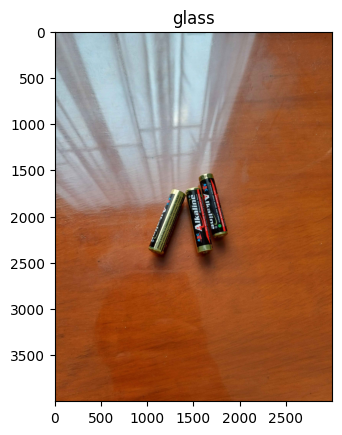

In [12]:
plt.imshow(cv2.cvtColor(cv2.imread("sample_battery.jpg"), cv2.COLOR_BGR2RGB))
plt.title(predict_image("sample_battery.jpg"))

1/1 [==============================] - 0s 26ms/step


Text(0.5, 1.0, 'paper')

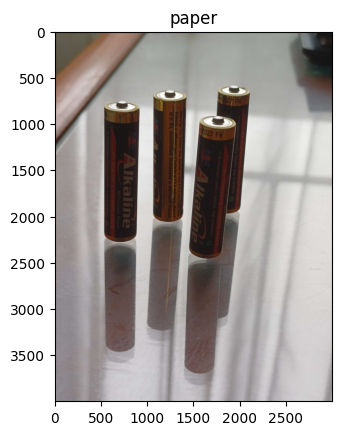

In [13]:
plt.imshow(cv2.cvtColor(cv2.imread("sample_battery_2.jpg"), cv2.COLOR_BGR2RGB))
plt.title(predict_image("sample_battery_2.jpg"))

1/1 [==============================] - 0s 25ms/step


Text(0.5, 1.0, 'plastic')

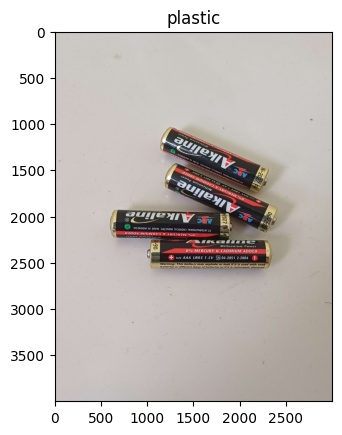

In [14]:
plt.imshow(cv2.cvtColor(cv2.imread("sample_battery_3.jpg"), cv2.COLOR_BGR2RGB))
plt.title(predict_image("sample_battery_3.jpg"))

1/1 [==============================] - 0s 25ms/step


Text(0.5, 1.0, 'battery')

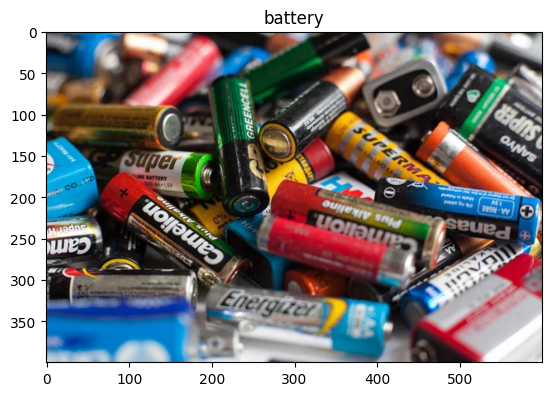

In [15]:
plt.imshow(cv2.cvtColor(cv2.imread("sample_battery_4.jpg"), cv2.COLOR_BGR2RGB))
plt.title(predict_image("sample_battery_4.jpg"))

1/1 [==============================] - 0s 26ms/step


Text(0.5, 1.0, 'battery')

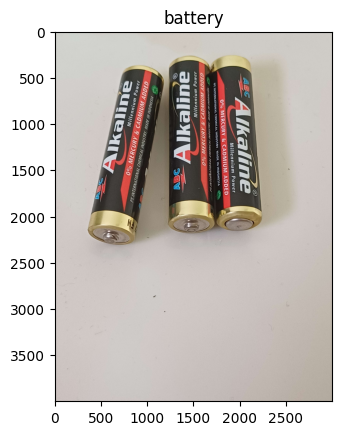

In [16]:
plt.imshow(cv2.cvtColor(cv2.imread("sample_battery_5.jpg"), cv2.COLOR_BGR2RGB))
plt.title(predict_image("sample_battery_5.jpg"))

1/1 [==============================] - 0s 27ms/step


Text(0.5, 1.0, 'battery')

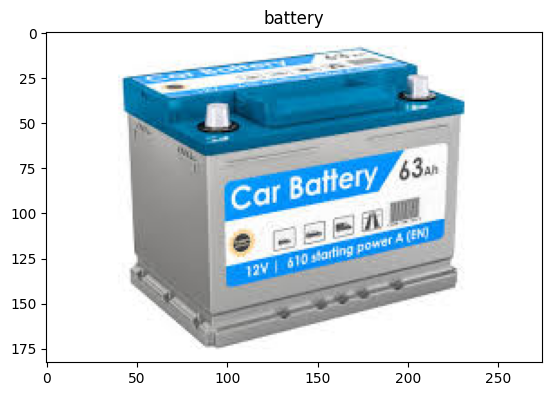

In [17]:
plt.imshow(cv2.cvtColor(cv2.imread("sample_battery_6.jpg"), cv2.COLOR_BGR2RGB))
plt.title(predict_image("sample_battery_6.jpg"))

Plastic

1/1 [==============================] - 0s 31ms/step


Text(0.5, 1.0, 'plastic')

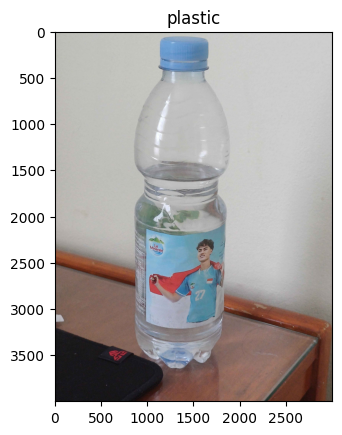

In [18]:
plt.imshow(cv2.cvtColor(cv2.imread("sample_plastic.jpg"), cv2.COLOR_BGR2RGB))
plt.title(predict_image("sample_plastic.jpg"))

1/1 [==============================] - 0s 28ms/step


Text(0.5, 1.0, 'paper')

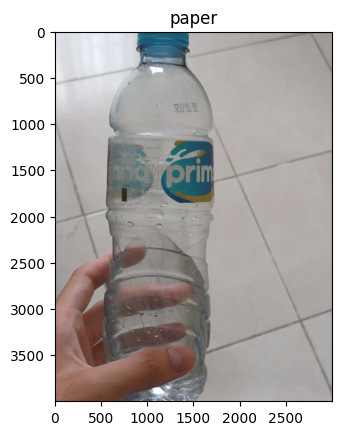

In [19]:
plt.imshow(cv2.cvtColor(cv2.imread("sample_plastic_2.jpg"), cv2.COLOR_BGR2RGB))
plt.title(predict_image("sample_plastic_2.jpg"))

Cloth

1/1 [==============================] - 0s 26ms/step


Text(0.5, 1.0, 'clothing_waste')

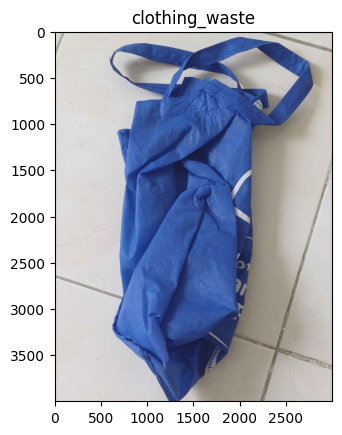

In [20]:
plt.imshow(cv2.cvtColor(cv2.imread("sample_cloth.jpg"), cv2.COLOR_BGR2RGB))
plt.title(predict_image("sample_cloth.jpg"))